# Analyse channel 1 - 4
here I will analyse and process channel 1 - 4 of Alsdorf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from ipywidgets import interact
import ipywidgets as widgets
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
from shutil import copy2 as copy_file

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data

plot_save=True #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #csv pickle #does not work for tlogger at the moment

# TO DO
# andere kalibrationsmethoden offenes ende --> Literatur lesen
# knick in dämpfung noch bearbeiten
# Vergleich mit anderen Kanälen systematisch machen

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")

Some Version information of the imported packages
pandas version: 1.2.3
pickle version: 4.0


In [2]:
#%%time
# Wall time: 1min 56s

# # Load csv data
if importer == "csv":
    data_2019 = import_my_database_csv(2019, path_to_my_database + r"\csv")
    data_2020 = import_my_database_csv(2020, path_to_my_database + r"\csv")
    data_2021 = import_my_database_csv(2021, path_to_my_database + r"\csv")

In [3]:
# # Load pickle Data
# if importer == "pickle":
#     data_all = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_all")

# # delete egrt cable channels
# for egrt_chan in ["5","6","7","8"]:
#     del data_all[egrt_chan]

In [4]:
# # import tlogger
# # read csv
# # Tlogger_PT1000 = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000.csv", index_col=[0])
# # Tlogger_PT100  = pd.read_csv(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated.csv",index_col=[0])
# # Tlogger_PT100.index.names=["Date"]; Tlogger_PT1000.index.names=["Date"]
# # Tlogger_PT100.index = pd.to_datetime(Tlogger_PT100.index); Tlogger_PT1000.index = pd.to_datetime(Tlogger_PT1000.index)

# #read_pickle
# df_Tlogger_PT1000 = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT1000")
# df_Tlogger_PT100  = read_pickle(path_to_my_database + "\\t_logger_watertank\\Tlogger_PT100_outdated")

# watertank_T_range_min = df_Tlogger_PT100.index.min()
# watertank_T_range_max = df_Tlogger_PT100.index.max()

# df_Tlogger_PT100

# Process Data
copied from other script and adjusted

additional processing of the data, e.g. delete outlier, align dataframes so that the dates fit

In [5]:
# data_all_processed = cut_dataframe_to_range_tlogger(channels=["1","2","3","4"],data=data_all,watertank_T_range_min=watertank_T_range_min, watertank_T_range_max=watertank_T_range_max)

In [6]:
diff = data_all_processed["1"].index[1:]-data_all_processed["1"].index[:-1]
diff.sort_values()

NameError: name 'data_all_processed' is not defined

In [ ]:
# a=data_all_processed
# ###################### Correct date missmatch, must be done manually at the moment####################################
# #print("--- Before removing date points ---")
# #check_first_last_date(a,channels=["1","2","3","4"])
# #print("--- --- --- --- --- --- --- --- --- ---")
# # Warum gibt es diesen unterschied ??????
# a["1"] = a["1"].drop(a["1"].index[0:13],axis=0)
# a["2"] = a["2"].drop(a["2"].index[0:7],axis=0)
# a["3"] = a["3"].drop(a["3"].index[0:4],axis=0)

# a["2"] = a["2"].drop(a["2"].index[-6:],axis=0)
# a["3"] = a["3"].drop(a["3"].index[-9:],axis=0)
# a["4"] = a["4"].drop(a["4"].index[-14:],axis=0)

# a["1"] = a["1"].drop(a["1"].index[2125],axis=0)
# a["2"] = a["2"].drop(a["2"].index[2125],axis=0)
# a["3"] = a["3"].drop(a["3"].index[2125],axis=0)

# # Check if the changes are as expected
# print("--- After removing some date points ---")
# check_first_last_date(a,channels=["1","2","3","4"])
# ####################################################################################################################

--- After removing some date points ---

Channel: 1; Number of dates: 2914
first (oldes) date: 2021-06-07 19:08:40
last (newest) date: 2021-08-09 00:09:15

Channel: 2; Number of dates: 2914
first (oldes) date: 2021-06-07 19:12:40
last (newest) date: 2021-08-09 00:13:15

Channel: 3; Number of dates: 2914
first (oldes) date: 2021-06-07 19:16:40
last (newest) date: 2021-08-09 00:17:15

Channel: 4; Number of dates: 2914
first (oldes) date: 2021-06-07 19:20:40
last (newest) date: 2021-08-09 00:21:15


# Check processing steps
als funktion machen und importieren in allen meinen notebooks

In [ ]:
# # Check my processed data
# my_Warning = check_processed_data(channels = ["1","2","3","4"], data_all_processed = data_all_processed)

Check timedifferences between channels: done
Check first and last date: done
Check number date measurements: done
All checks passed


In [ ]:
for chan in ["1","2","3","4"]:
    data_all[chan] = data_all[chan][::5] #only use every 5th row
    data_all_processed[chan] = data_all_processed[chan][::5] #only use every 5th row

# Watertank shift

In [ ]:
# #%%time
# #Wall time: 26.2 s
# watertank_len=[71] # position DTS cable, where it is in watertank
# # Wie habe ich aktuell die Wassertank positionen bestimmt: 
# # watertank angeguckt und die position finden wo starke änderrungen sind über die Zeit sin --> draußen
# # Zwei bis drei Längeneinheiten richtung DTS Gerät gegangen, dort sind dann keine starken Änderrungen über die Zeit 
#     # --> Wassertankposition
# # Dann die Dataframes von den Channeln die ich mittele so bearbeiten, dass genau die Wassertank positionen gemittelt werden
#     # ein parr Längen /Spalten entfernt
# # Positionen sind nicht ganz richtig, oder Längen die vom DTS Kabel generiert wurden stimmen nicht

# # Correction for waterteank temp difference
# data_all_processed_shifted, watertank_diff_log_data_all = watertank_shift(data_all_processed, df_Tlogger, channels=["1","2","3","4"], watertank_len=watertank_len, watertank_T_range_min=watertank_T_range_min,watertank_T_range_max=watertank_T_range_max)

In [ ]:
# # get mean watertank diff correction value to correct older data
# mean_watertank_diff={}
# for chan in ["1","2","3","4"]:
#     mean_watertank_diff[chan] = watertank_diff_log_data_all[chan].loc[watertank_len[0]].mean()

# # Correct all values with mean shift
# data_all_shifted={}
# for chan in ["1","2","3","4"]:
#     data_all_shifted[chan] = data_all[chan] - mean_watertank_diff[chan]

# Plot watertank correction

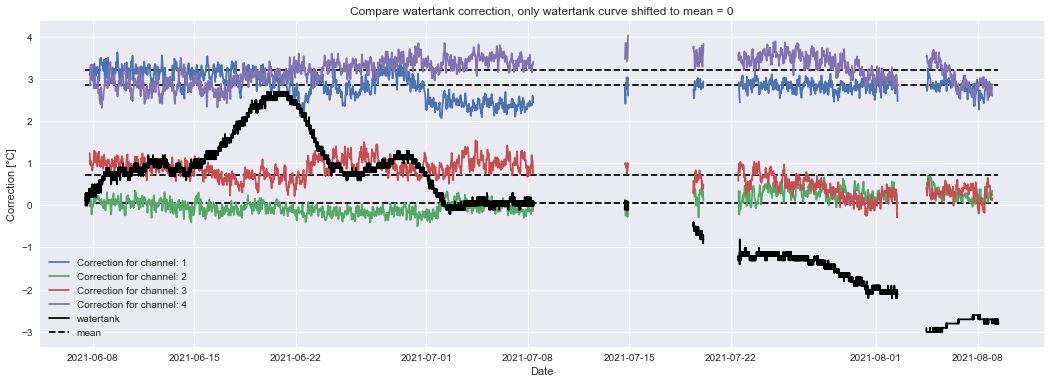

In [ ]:
# fig,axs=plt.subplots(1,1,figsize=(18,6))
# # for chan in watertank_diff_log_data_all.keys():
# #     # shift everything to mean = 0
# #     mean=np.nanmean(watertank_diff_log_data_all[chan].loc[watertank_len[0]])
# #     y=watertank_diff_log_data_all[chan].loc[watertank_len[0]] - mean

# #     axs[0].plot(watertank_diff_log_data_all[chan].columns,y,label=f"Correction for channel: {chan}")
# # # plot watertank Temp for comparisson
# # mean = np.nanmean(df_Tlogger["Channel1-Watertank_PT100"].values)
# # y=df_Tlogger["Channel1-Watertank_PT100"].values - mean
# # x_dates=df_Tlogger["Channel1-Watertank_PT100"].index
# # axs[0].plot(x_dates,y,color="black", label="watertank")

# # axs[0].set_title("Compare watertank correction, all curves shifted to mean = 0")
# # axs[0].set_xlabel("Date")
# # axs[0].set_ylabel("Correction [°C]")
# # axs[0].legend()

# mean = mean_watertank_diff["1"]
# x = df_Tlogger["Channel1-Watertank_PT100"].index
# axs.hlines(mean,x.min(),x.max(),linestyle="--",color="black",label="mean")
# for chan in ["2","3","4"]:
#     mean = mean_watertank_diff[chan]
#     axs.hlines(mean,x.min(),x.max(),linestyle="--",color="black")

# # Plot, only shift watertank to mean 0
# for chan in watertank_diff_log_data_all.keys():
#     y=watertank_diff_log_data_all[chan].loc[watertank_len[0]]

#     axs.plot(watertank_diff_log_data_all[chan].columns,y,label=f"Correction for channel: {chan}")

# # plot watertank Temp for comparisson
# mean = np.nanmean(df_Tlogger["Channel1-Watertank_PT100"].values)
# y=df_Tlogger["Channel1-Watertank_PT100"].values - mean
# x_dates=df_Tlogger["Channel1-Watertank_PT100"].index
# axs.plot(x_dates,y,color="black", label="watertank")

# axs.set_title("Compare watertank correction, only watertank curve shifted to mean = 0")
# axs.set_xlabel("Date")
# axs.set_ylabel("Correction [°C]")
# axs.legend()

# plt.show()

In [ ]:
# # save corrected data
# write_pickle("./data_all_processed_shifted_ch1-4",data_all_processed_shifted) # I use this as comparisson in another skript

# Compare EGRT Cable channel 1 - 4 to Wireline T-Logger 2020

In [ ]:
# Load Wireline data
path_to_wireline = path_to_my_database + "\PTS_Logs"

filename2003=r"\PTS_2003.csv"
wireline_measurements2003 = pd.read_csv(path_to_wireline + filename2003,skiprows=[0,2,3],index_col=0,na_values=-999.0)
wireline_measurements2003.columns = ["BHT","CBLE_ACC","CURRENT","DIFF-TENSION0","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME","VOLTAGE"] #rename columns, because the original names contain empty spaces
wireline_measurements2003 = wireline_measurements2003.dropna()

filename2020=r"\PTS_20201124.csv"
wireline_measurements2020 = pd.read_csv(path_to_wireline + filename2020,index_col=0,skiprows=[0,2,3],na_values=-999.0)
wireline_measurements2020.columns = ["BHT","DEPTH.1","dPress","GAMMA","MEASURERANGE","PRESS","SAL","SPEED","TENSION","TIME"]
wireline_measurements2020 = wireline_measurements2020.drop(columns=["DEPTH.1"]) # the same as DEPTH column
wireline_measurements2020 = wireline_measurements2020.dropna() # drop some nan rows

In [ ]:
# Calc diff to wireline
diff_to_wireline = {}
shaft_data = pd.DataFrame(index=np.arange(160,576,1),columns=["dts chan 1","dts chan 2","dts chan 3","dts chan 4","wireline"])
shaft_data.index.names=["Depth"]

shaft_data["wireline"] = wireline_measurements2020["BHT"][160 : 575][::20].values #skip air and not trusted, only use datapoints every meter
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
    shaft_data[f"dts chan {chan}"] = data_all_shifted[chan].loc[date_name][200 + 160: 575+201].values #skip first 200 and air and not trusted
    diff_to_wireline[chan] = shaft_data[f"dts chan {chan}"] - shaft_data["wireline"]

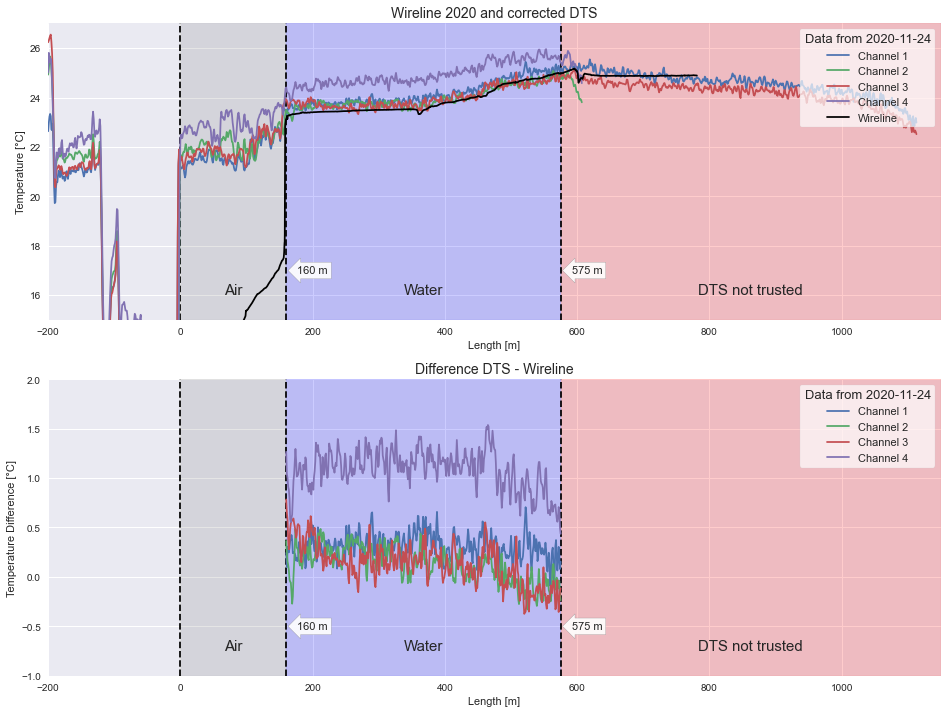

In [ ]:
# compare shifted data to wireline
def color_cable_pos(start_len, end_len, col, ymax, ymin, label_name, axs, label=True):
    """ creates patches which color the plot"""
    width = end_len - start_len
    Rectangle=patches.Rectangle(xy=[start_len,ymin],width=width,height=(ymax-ymin),color=col,alpha=0.2)
    axs.add_patch(Rectangle)
    if label:
        #axs.annotate(label_name,[start_len+width/2, ymax-(ymax-ymin)*0.9],size=15)
        bbox_props=dict(boxstyle="round",fc=col, ec="0.5", alpha=0.0)
        axs.text(start_len+width/2,ymax-(ymax-ymin)*0.1,label_name,ha="center",va="center",size=15,bbox=bbox_props)

offset = 200 # muss ich noch genauer nachgucken
fig, axs = plt.subplots(2,1,figsize=[16,12])

axs[0].set_title("Wireline 2020 and corrected DTS", fontsize = 14)
axs[0].set_ylabel("Temperature [°C]")
ylim=[15,27]
axs[0].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
    axs[0].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"Channel {chan}") #\nTime: {date_name[11:-3]}
axs[0].plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline",color="black")
#color plot
axs[0].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[0].text(575 + 40, 17,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[0].text(160 + 40, 17,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[0])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[0])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[0])

#####################################################################################

axs[1].set_ylabel("Temperature Difference [°C]")
axs[1].set_title("Difference DTS - Wireline", fontsize = 14)
ylim=[-1,2]
axs[1].set_ylim(ylim)
for chan in ["1","2","3","4"]:
    axs[1].plot(diff_to_wireline[chan],label=f"Channel {chan}")
#color plot
axs[1].vlines([0,160,575],ylim[0],ylim[1],color="black",linestyle="--")
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
axs[1].text(575 + 40, -0.5,"575 m", ha=ha, va=va, size=size, bbox=bbox_props)
axs[1].text(160 + 40, -0.5,"160 m", ha=ha, va=va, size=size, bbox=bbox_props)
color_cable_pos(575,1150,"red",ylim[0],ylim[1],"DTS not trusted",axs[1])
color_cable_pos(0,160,"gray",ylim[0],ylim[1],"Air",axs[1])
color_cable_pos(160,575,"blue",ylim[0],ylim[1],"Water",axs[1])

for ax in axs:
    ax.set_xlim([-200,1150])
    ax.set_xlabel("Length [m]")
    legend = ax.legend(fontsize=11,title="Data from 2020-11-24", title_fontsize=11+2, frameon=True, loc="upper right")
    legend.get_frame().set_alpha(0.7)
    legend.get_frame().set_facecolor("white")

if plot_save:
    plt.savefig("pictures\compare_wireline2020.png")
    plt.savefig("pictures\compare_wireline2020.png",dpi=720)

# Accuracy vom Temp log 0.5 - 1 °C? -- > nachfragen
# https://www.maximintegrated.com/en/design/technical-documents/app-notes/3/3892.html

In [ ]:
# Old plot not needed, when shift of older data is approved to be good

# # Compare Wireline with Channel 1-4
# offset=200 # muss ich noch genauer nachgucken
# fig,axs=plt.subplots(3,1,figsize=[16,15])
# axs[0].set_title("Wireline 2020 - DTS corrected")
# axs[1].set_title("Wireline 2020 - DTS uncorrected")
# for chan in ["1","2","3","4"]:
#     date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
#     axs[0].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"{chan}: {date_name}")
#     date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all[chan].index)
#     axs[1].plot(data_all[chan].loc[date_name].index - offset,data_all[chan].loc[date_name].values,label=f"{chan}: {date_name}")
# for ax in [axs[0],axs[1]]:
#     ax.plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline 2020-11-24",color="black")
#     ax.legend()
#     ax.set_xlabel("Length [m]")
#     ax.set_ylabel("Temperature [°C]")

# # axs[0,1].set_title("Wireline 2003 - DTS corrected")
# # axs[1,1].set_title("Wireline 2003 - DTS uncorrected")
# # for chan in ["1","2","3","4"]:
# #     date_name, date_iloc = find_nearest_date("2003-12-04 12:00:00",data_all_shifted[chan].index)
# #     axs[0,1].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values,label=f"{chan}: {date_name}")
# #     axs[1,1].plot(data_all[chan].loc[date_name].index - offset,data_all[chan].loc[date_name].values,label=f"{chan}: {date_name}")
# # for ax in [axs[0,1],axs[1,1]]:
# #     ax.plot(wireline_measurements2003["BHT"].index,wireline_measurements2003["BHT"].values,label="Wireline 2003-12-04",color="black")
# #     ax.legend()
# #     ax.set_xlabel("Length [m]")
# #     ax.set_ylabel("Temperature [°C]")

# axs[2].set_title("Wireline 2020 - DTS corrected additonal -1.5 shift")
# for chan in ["1","2","3","4"]:
#     date_name, date_iloc = find_nearest_date("2020-11-24 12:00:00",data_all_shifted[chan].index)
#     axs[2].plot(data_all_shifted[chan].loc[date_name].index - offset,data_all_shifted[chan].loc[date_name].values -1.5,label=f"{chan}: {date_name}")
# for ax in [axs[2]]:
#     ax.plot(wireline_measurements2020["BHT"].index,wireline_measurements2020["BHT"].values,label="Wireline 2020-11-24",color="black")
#     ax.legend()
#     ax.set_xlabel("Length [m]")
#     ax.set_ylabel("Temperature [°C]")

# for ax in [axs[0],axs[1],axs[2]]:
#     ax.set_ylim([5,30])

# #plt.savefig("pictures/Ch1-4_wireline.png",dpi=720)

# # andere Zeitpunkte von dem Tag passen auch nicht besser

# Extract shaft
from processed data

In [ ]:
begin_shaft=200 # muss ich noch genauer nachgucken
# muss auch noch genauer überprüft werden, dieser Wert beschreibt wie weit die Faser von Channel 1 und 3 geht, bevor sie wieder nach oben geht
complete_shaft_length = 800
shaft={}
for chan in ["1","2","3","4"]:
    if chan in ["2","4"]: #shorter channels
        col = data_all_processed_shifted[chan].columns[begin_shaft:]
    if chan in ["1","3"]: #longer channels
        col = data_all_processed_shifted[chan].columns[begin_shaft:begin_shaft + complete_shaft_length]
    shaft[chan] = data_all_processed_shifted[chan][col]
    shaft[chan].columns = np.arange(0,shaft[chan].columns.max() + 1 - begin_shaft)
    shaft[chan].columns.names=["Depth [m]"]
    shaft[chan] = round(shaft[chan],2)


In [ ]:
# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_to_my_database + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

## Plot Shaft Temperature

Channel 1 shifted, last length 1113
Channel 2 shifted, last length 607
Channel 3 shifted, last length 1114
Channel 4 shifted, last length 607
bend point would be at 860.0, if assuming the DTS measurements exactly stop at the fibre break
die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?


Text(0, 0.5, 'Temperature [°C]')

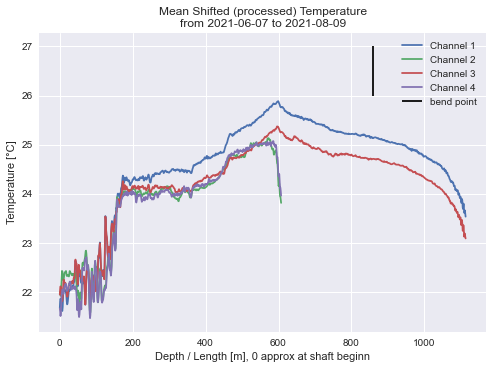

In [ ]:
begin_shaft = 200
last_length={}
for channel in ["1","2","3","4"]:
    last_length[channel] = data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[begin_shaft:]].columns.max() - begin_shaft
    print(f"Channel {channel} shifted, last length {last_length[channel]}")
bend_point=last_length["2"] + (last_length["1"] - last_length["2"]) / 2
print(f"bend point would be at {bend_point}, if assuming the DTS measurements exactly stop at the fibre break")
print("die werte  passen nicht zu S. 48 im Abschlussbericht, da war das DTS Gerät irgendwie anders angeschlossen?")

#Plot shifted data
for channel in ["1","2","3","4"]:
    y=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].mean(axis=0).values
    x=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].mean(axis=0).index - 200
    plt.plot(x,y, label=f"Channel {channel}")
plt.vlines([bend_point],26,27,color="black",label="bend point")
plt.legend()
min_date=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].index.min().strftime("%Y-%m-%d")
max_date=data_all_processed_shifted[channel][data_all_processed_shifted[channel].columns[200:]].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Shifted (processed) Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth / Length [m], 0 approx at shaft beginn")
plt.ylabel("Temperature [°C]")

## Interpretation
* ist knick bei depth 600 realer Temperaturänderung im Schacht? Die kurzen Kabel gehen bis ca. 600. 
    * Dieser Knick ist also bei der selben Tiefe wo das Kabel gebrochen ist. (Aus der Sicht von Channel 1 und 3 ist es auf dem Weg hoch gebrochen). 
* Ist es nicht auch verwunderlich, dass nur zwei der 4 Fasern an der Stelle gebrochen sind? Die anderen werden auch in irgendeinareweise Schaden erlitten haben?!
* Bei ca. 850 geht das Kabel irgendwann wieder hoch, ist aber nicht zu sehen, eigentlich müsste es ja symmetrisch sein ab dem Punkt wo es wieder hochgeht.
* Das der Kabelbruch Punkte von vorher beeinflusst kann eigentlich nicht sein, da das Licht ja noch gar nicht bis zum Kabelbruch gekommen ist. Beschädigungen am Kabel können also nur Punkte die später kommen beeinflussen.
* Bei ca. 0 (shaft begin) sieht man in den backscattered Daten eine Dämpfungsänderrung. Dort wurden Kabel gespleißt??????
* Bei 600 - 608 m sind bei der Kamerabefahrung Seile gefunden worden: ANh01 Fotot 18; Abschlussbericht S. 44
  * war die in der Pegelleitung oder im Schacht?

# Compare Channel 1-4 and Channel 5-8
Here I use the final corrected data for comparisson. The results should be "equal"

Text(0, 0.5, 'Temperature [°C]')

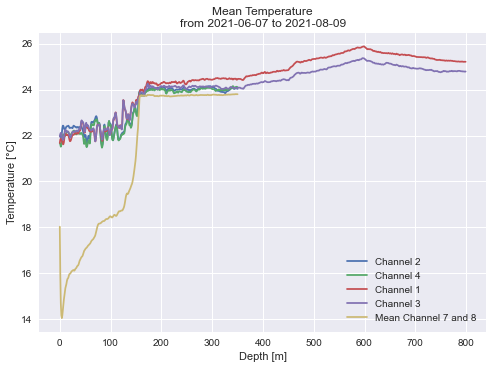

In [ ]:
#both datafames have the same number of rows and dates are similar
plt.plot(shaft["2"][Schacht_7and8_down.columns].mean(axis=0).index,shaft["2"][Schacht_7and8_down.columns].mean(axis=0).values, label="Channel 2")
plt.plot(shaft["4"][Schacht_7and8_down.columns].mean(axis=0).index,shaft["4"][Schacht_7and8_down.columns].mean(axis=0).values, label="Channel 4")
plt.plot(shaft["1"].mean(axis=0).index,shaft["1"].mean(axis=0).values, label="Channel 1")
plt.plot(shaft["3"].mean(axis=0).index,shaft["3"].mean(axis=0).values, label="Channel 3")
plt.plot(Schacht_7and8_down[12:-13].mean(axis=0).index,Schacht_7and8_down[12:-13].mean(axis=0).values, label= "Mean Channel 7 and 8")
plt.legend()
min_date=shaft["2"][Schacht_7and8_down.columns].index.min().strftime("%Y-%m-%d")
max_date=shaft["2"][Schacht_7and8_down.columns].index.max().strftime("%Y-%m-%d")
plt.title(f"Mean Temperature\nfrom {min_date} to {max_date}")
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")

In [ ]:
# Calc diff to EGRT cable
channel="3"
data1 = shaft[channel][Schacht_7and8_down.columns]
data2 = Schacht_7and8_down[12:-13] #both datafames have the same number of rows and dates are similar
diff_othercable = calc_diff_between_channels(data1, data2, expected_difference_minutes=15)
diff_statistic = calc_stat_of_difference(diff_othercable["diff_abs"].transpose())

# diese Berechnung könnte ich auch für jeden Channel machen, aber man sieht ja oben, dass das keinen großen Unterschied macht

Warning 1: large time difference
0 days 00:22:02


In [ ]:
#px.imshow(diff_othercable["diff"],zmin=-2,zmax=2)

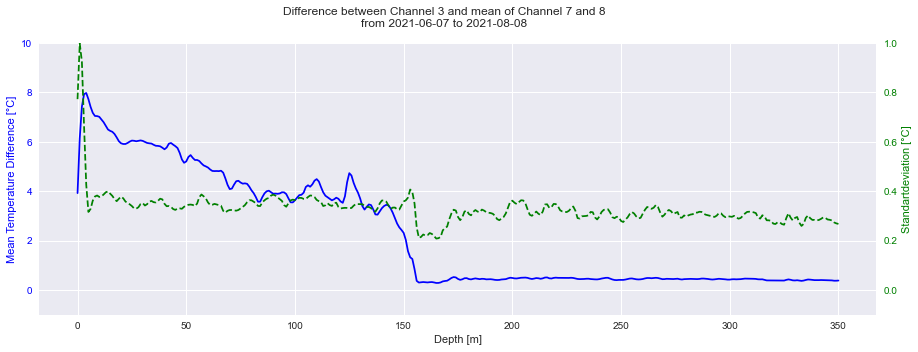

In [ ]:
# Plot difference
##########Inputs##########
ymin=-1;ymax=10
cmean="blue";cstdev="green"
lstyle_mean="-";lstyle_stdev="--"
######################
fig,axs=plt.subplots(1,1,figsize=[15,5])#,constrained_layout=True)
min_date=diff_othercable["diff_abs"].columns.min().strftime("%Y-%m-%d")
max_date=diff_othercable["diff_abs"].columns.max().strftime("%Y-%m-%d")
fig.suptitle(f"Difference between Channel {channel} and mean of Channel 7 and 8\nfrom {min_date} to {max_date}")
#fig.tight_layout()

axs.plot(diff_statistic.loc["mean"].index,diff_statistic.loc["mean"].values,label="mean",color=cmean,linestyle=lstyle_mean)#label="Bottom Hole Temperature"
axs.set_xlabel("Depth [m]")
axs.set_ylabel("Mean Temperature Difference [°C]",color=cmean)
axs.set_ylim(ymin,ymax) # both y-axis have similar scale --> helper lines are alligned
axs.tick_params(axis='y', labelcolor=cmean)

axs0_2 = axs.twinx()
axs0_2.plot(diff_statistic.loc["stdev"].index,diff_statistic.loc["stdev"].values,label="stdev",color=cstdev,linestyle=lstyle_stdev) #,label="Salinity")
axs0_2.set_ylabel('Standartdeviation [°C]', color=cstdev)
axs0_2.set_ylim(ymin/10,ymax/10) # both y-axis have similar scale --> helper lines are alligned
axs0_2.tick_params(axis='y', labelcolor=cstdev)
# The grids are not alligned, if not using .set_ylim()
axs0_2.grid(None) #axs is behind the helper lines

### Interpretation
* Im Wasser sind sich die Ergebnisse sehr ähnlich. Vorher nicht, warum? EGRT Kabel geht durch eine Pegelleitung, wie muss ich mir das vorstellen, ist das bis zum Boden des Schachts ein seperates Rohr?
* Dadurch, dass sich diese Ergebnisse so ähnlich sind, würde ich davon ausgehen, dass mindestens dieser Bereich eine plausible Temperatur angibt.
    * Allerdings passt es ja nicht zum Wireline-log. 
        * **Entweder die Kalibration kann nicht so einfach in die Vergangenhait übertragen werden**
        * **Oder Meine gemessene Wassertank Temperatur ist falsch?** --> Also komplette Kalibration falsch?

* Die ersten 151.6 m gehen Channel 1-4 durch eine Bohrung im Beton. 
* Channel 5-8 gehen die durch ein anderes Rohr, eine Pegelleitung

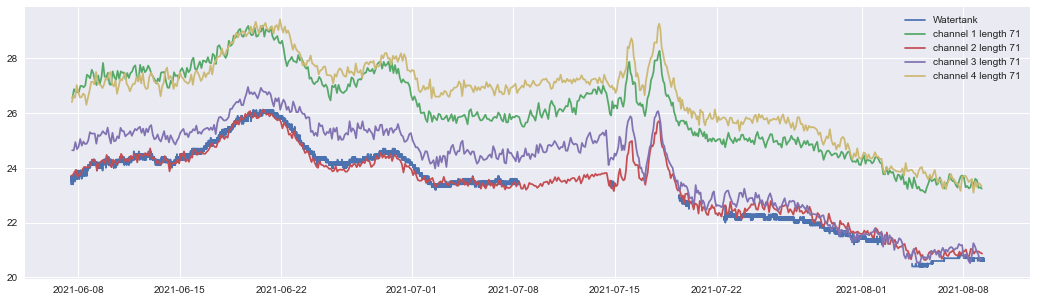

In [ ]:
# Compare watertank to uncorrected channels
# to find where the watertank position is
watertank = 71 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank_PT100"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_all[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].index
    val=data_all[c][str(df_Tlogger.index.min()) : str(df_Tlogger.index.max())][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")

plt.legend()

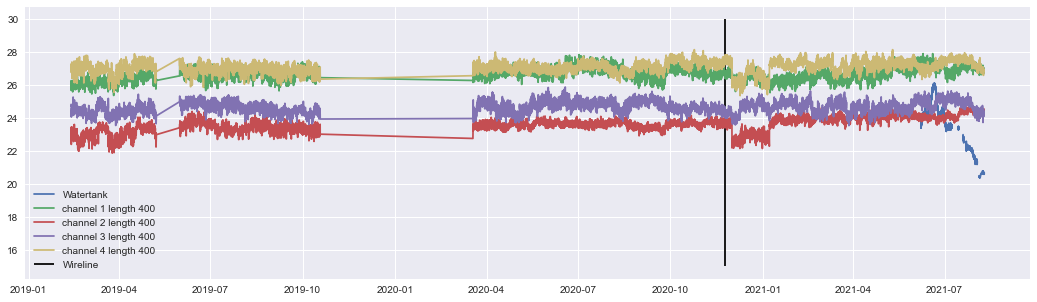

In [ ]:
# Compare watertank to uncorrected channels
# to find where the watertank position is
watertank = 400 

plt.figure(figsize=(18,5))
plt.plot(df_Tlogger.index, df_Tlogger["Channel1-Watertank_PT100"], label="Watertank")
#plt.plot(df_Tlogger.index, df_Tlogger["Channel2-Air"], label="Air")
for c in ["1","2","3","4"]: 
    inde=data_all[c][watertank].index
    val=data_all[c][watertank].values
    plt.plot(inde,val, label=f"channel {c} length {watertank}")
plt.vlines(pd.to_datetime("2020-11-24 12:00:00"),15,30,color="black",label="Wireline")

plt.legend()

# temperatur Stadium des Wireline logs unterscheided sich um einige Grad vom aktuellen Stadium indem es Wassertank temperaturen gibt